# Bayesian VAR Tutorial

We consider the estimation of a **BVAR(1)** model using monthly data on Economic Policy Uncertainty Index ($epu_{t}$), Industrial Production Growth ($ip_{t}$), Consumption ($cons_{t}$), and Employment ($emp_{t}$) for the US from 1985m02 to 2019m12:

In [47]:
import pandas as pd

# Load the Economic Policy Uncertainty data and macro variables for US
df_epu = pd.read_csv("../datasets/EPU_US_Data.csv")
df_epu["date"] = pd.to_datetime(df_epu["date"], format="%m/%d/%y %H:%M")
df_epu.set_index('date', inplace=True) # this step is super important
df_epu.rename(columns={"g_indpro": "ip", "g_pce": "cons", "g_emp": "emp"}, inplace=True)
df_epu

,epu,ip,cons,emp
date,,,,
1985-02-01,78.313193,0.306571,0.461621,0.135747
1985-03-01,100.761475,0.131449,0.389519,0.350055
1985-04-01,84.778863,-0.197014,0.146093,0.201983
1985-05-01,98.053653,0.147953,0.236604,0.281569
1985-06-01,119.597150,-0.047696,0.269944,0.150833
...,...,...,...,...
2019-08-01,282.522931,0.731498,0.034504,0.153530
2019-09-01,186.640697,-0.237878,0.068054,0.136798
2019-10-01,159.511393,-0.914646,0.195611,0.085178


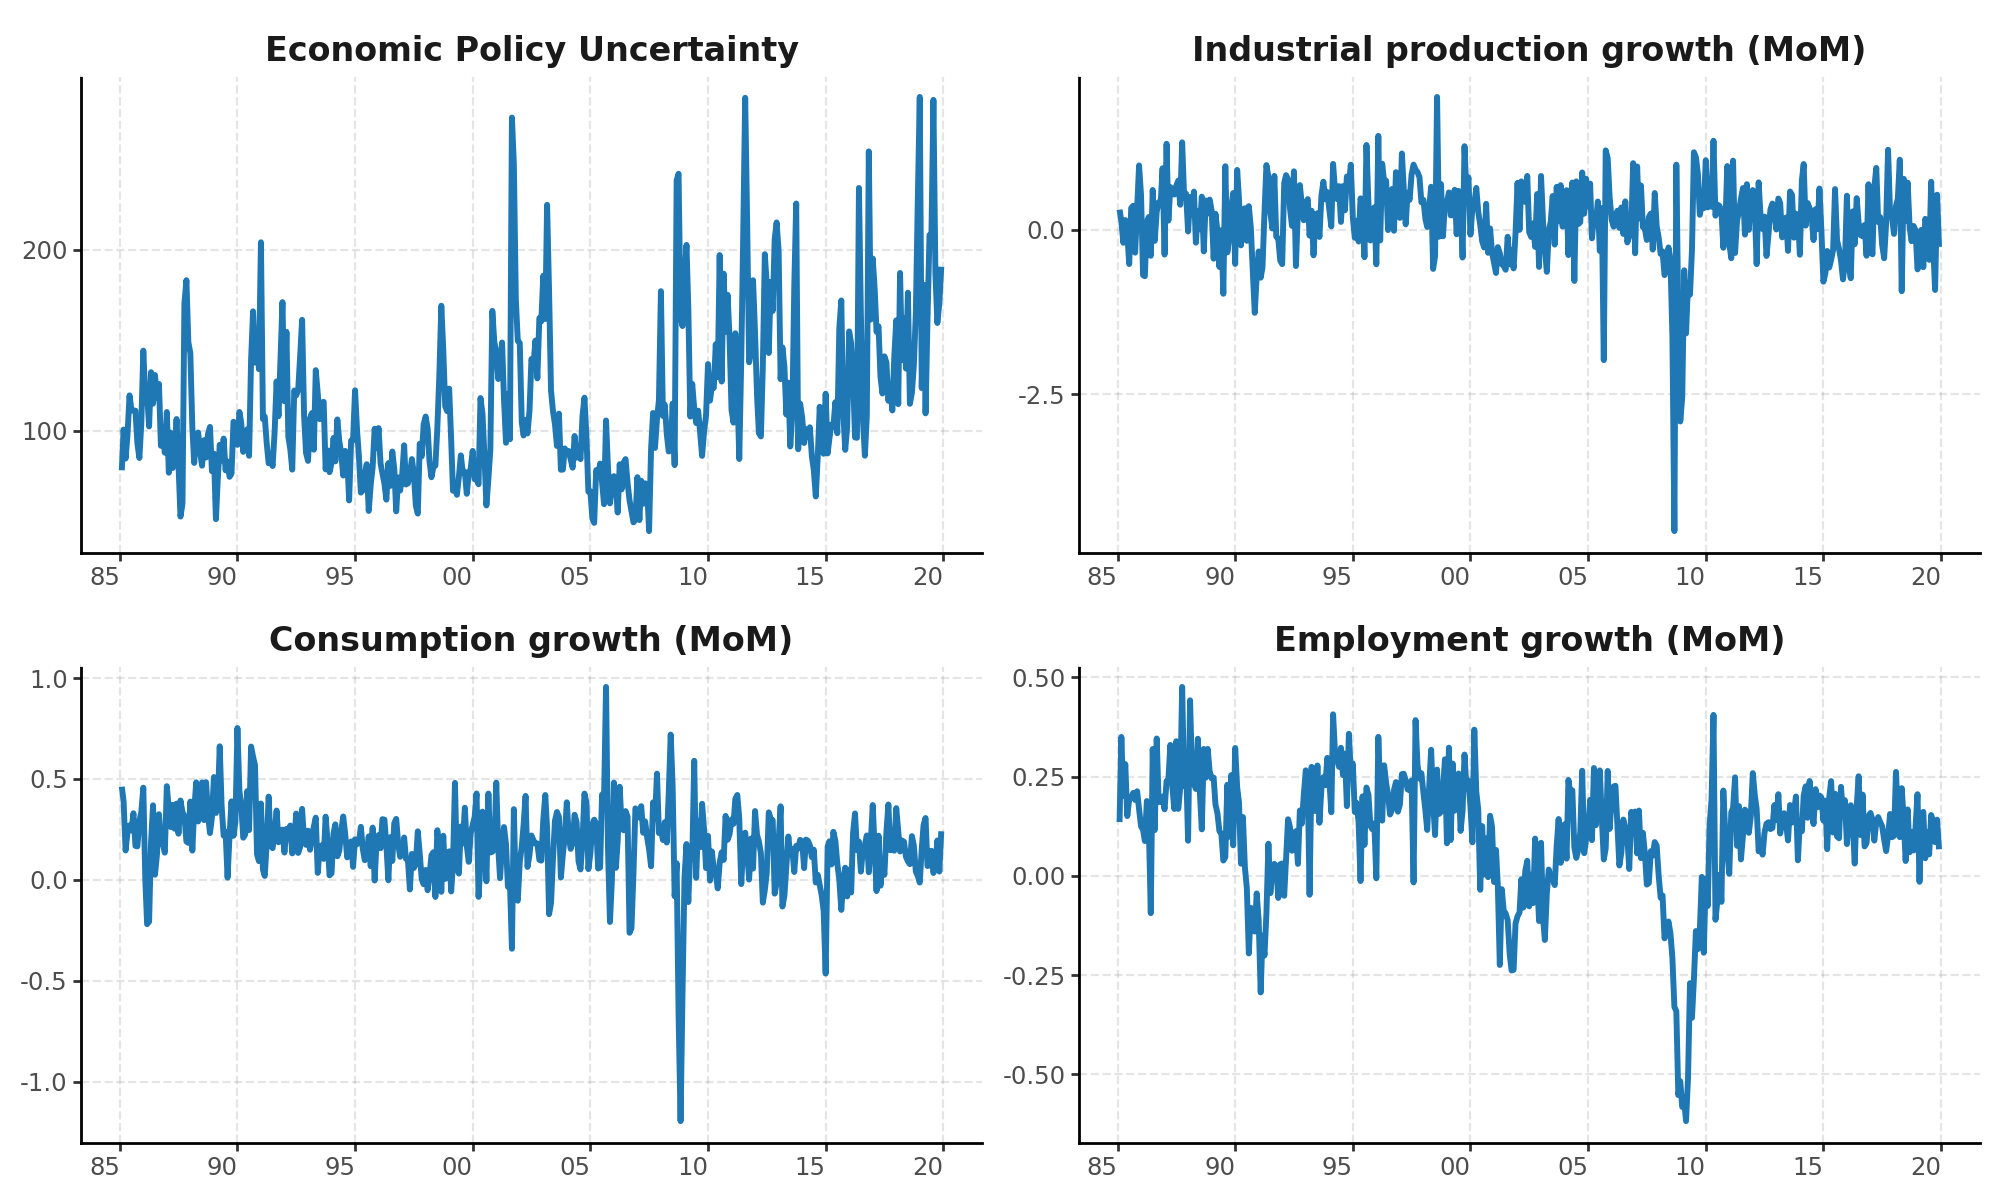

In [48]:
from MacroPy import generate_series_plot

# Generate a series plot for the Stock & Watson (2001) dataset
series_titles = ["Economic Policy Uncertainty", 
                 "Industrial production growth (MoM)", 
                 "Consumption growth (MoM)",
                 "Employment growth (MoM)"]
generate_series_plot(df_epu, series_titles=series_titles)

In [49]:
from MacroPy import BayesianVAR

prior_params = {"mn_mean": 0.75}
                      
bvar = BayesianVAR(df_epu, prior_type=2, prior_params=prior_params)
bvar.model_summary()


**MacroPy Toolbox for Macroeconometric Analysis in Python**  
Developed by [Renato Vassallo](https://www.linkedin.com/in/renatovassallo), Institute for Economic Analysis (IAE-CSIC)  
Version 0.1.2, May 2025  

---

**Model Specifications**  
- **Model Type**: Bayesian VAR  
- **Endogenous Variables**: epu, ip, cons, emp  
- **Exogenous Variables**: Constant   
- **Number of Lags**: 1  
- **Total Number of Coefficients to Estimate**: 20  

---

**MCMC Algorithm**: Gibbs Sampling  
- **Prior Type**: Normal-Wishart  
- **Iterations**: 5000  
- **Burn-in**: 2500 (50%)  

---

**Forecast & IRF Details**  
- **Impulse Response Horizon**: 20  
- **Forecast Horizon**: 12  
- **IRF Computation**: 1 Standard Deviation  

---

**VAR Model Equations**

$$
\begin{align*}
epu_{t} &= b_{1,1}^{1} epu_{t-1} + b_{1,2}^{1} ip_{t-1} + b_{1,3}^{1} cons_{t-1} + b_{1,4}^{1} emp_{t-1} + c_{1} + e_{t}^{epu} \\
ip_{t} &= b_{2,1}^{1} epu_{t-1} + b_{2,2}^{1} ip_{t-1} + b_{2,3}^{1} cons_{t-1} + b_{2,4}^{1} emp_{t-1} + c_{2} + e_{t}^{ip} \\
cons_{t} &= b_{3,1}^{1} epu_{t-1} + b_{3,2}^{1} ip_{t-1} + b_{3,3}^{1} cons_{t-1} + b_{3,4}^{1} emp_{t-1} + c_{3} + e_{t}^{cons} \\
emp_{t} &= b_{4,1}^{1} epu_{t-1} + b_{4,2}^{1} ip_{t-1} + b_{4,3}^{1} cons_{t-1} + b_{4,4}^{1} emp_{t-1} + c_{4} + e_{t}^{emp} \\
\end{align*}
$$


Sampling Posterior: 100%|██████████| 5000/5000 [00:00<00:00, 8572.20it/s]


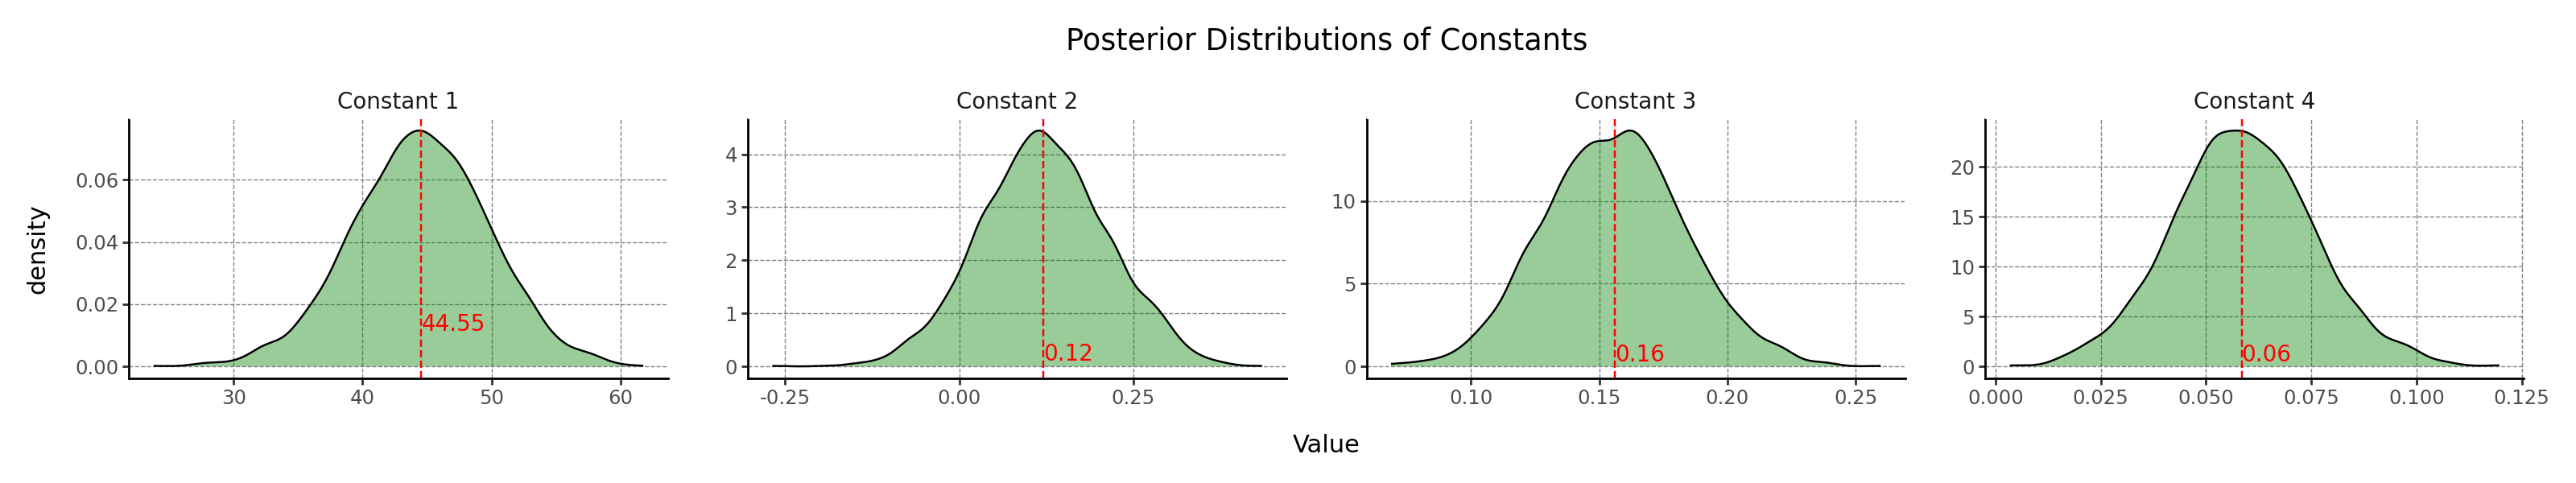

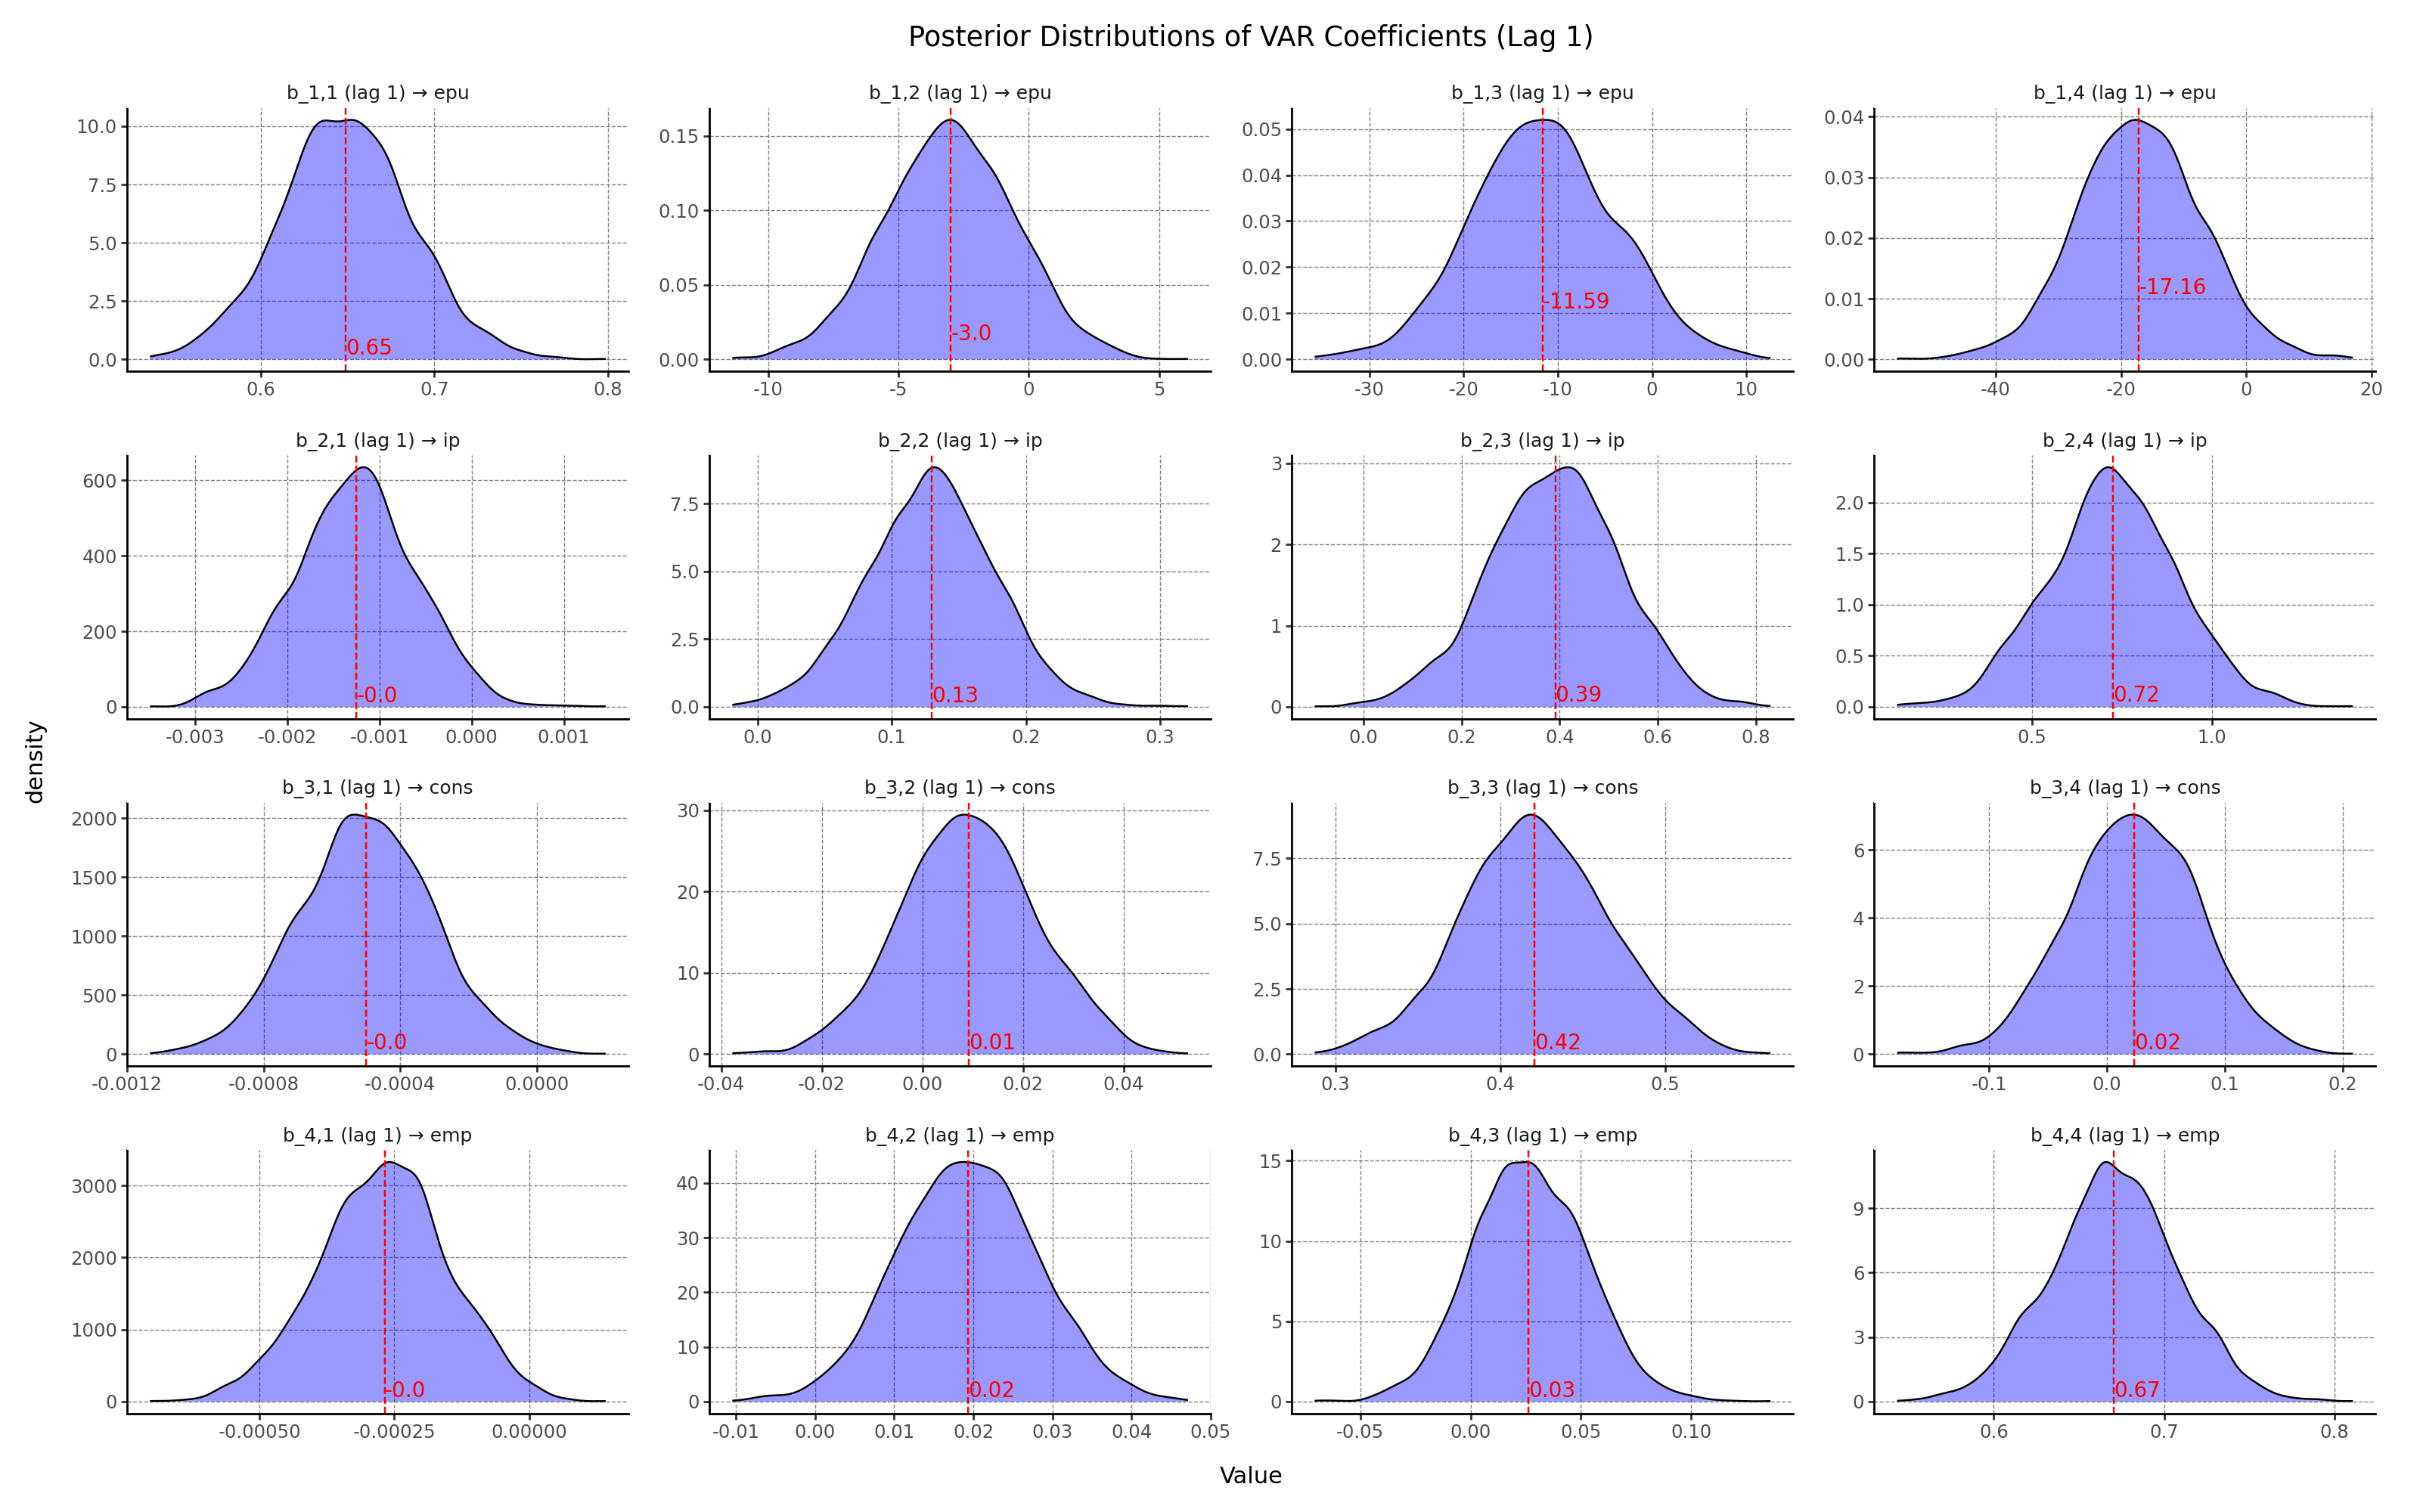

In [50]:
bvar.sample_posterior(plot_coefficients=True)

Computing IRFs: 100%|██████████| 2500/2500 [00:00<00:00, 3348.50it/s]


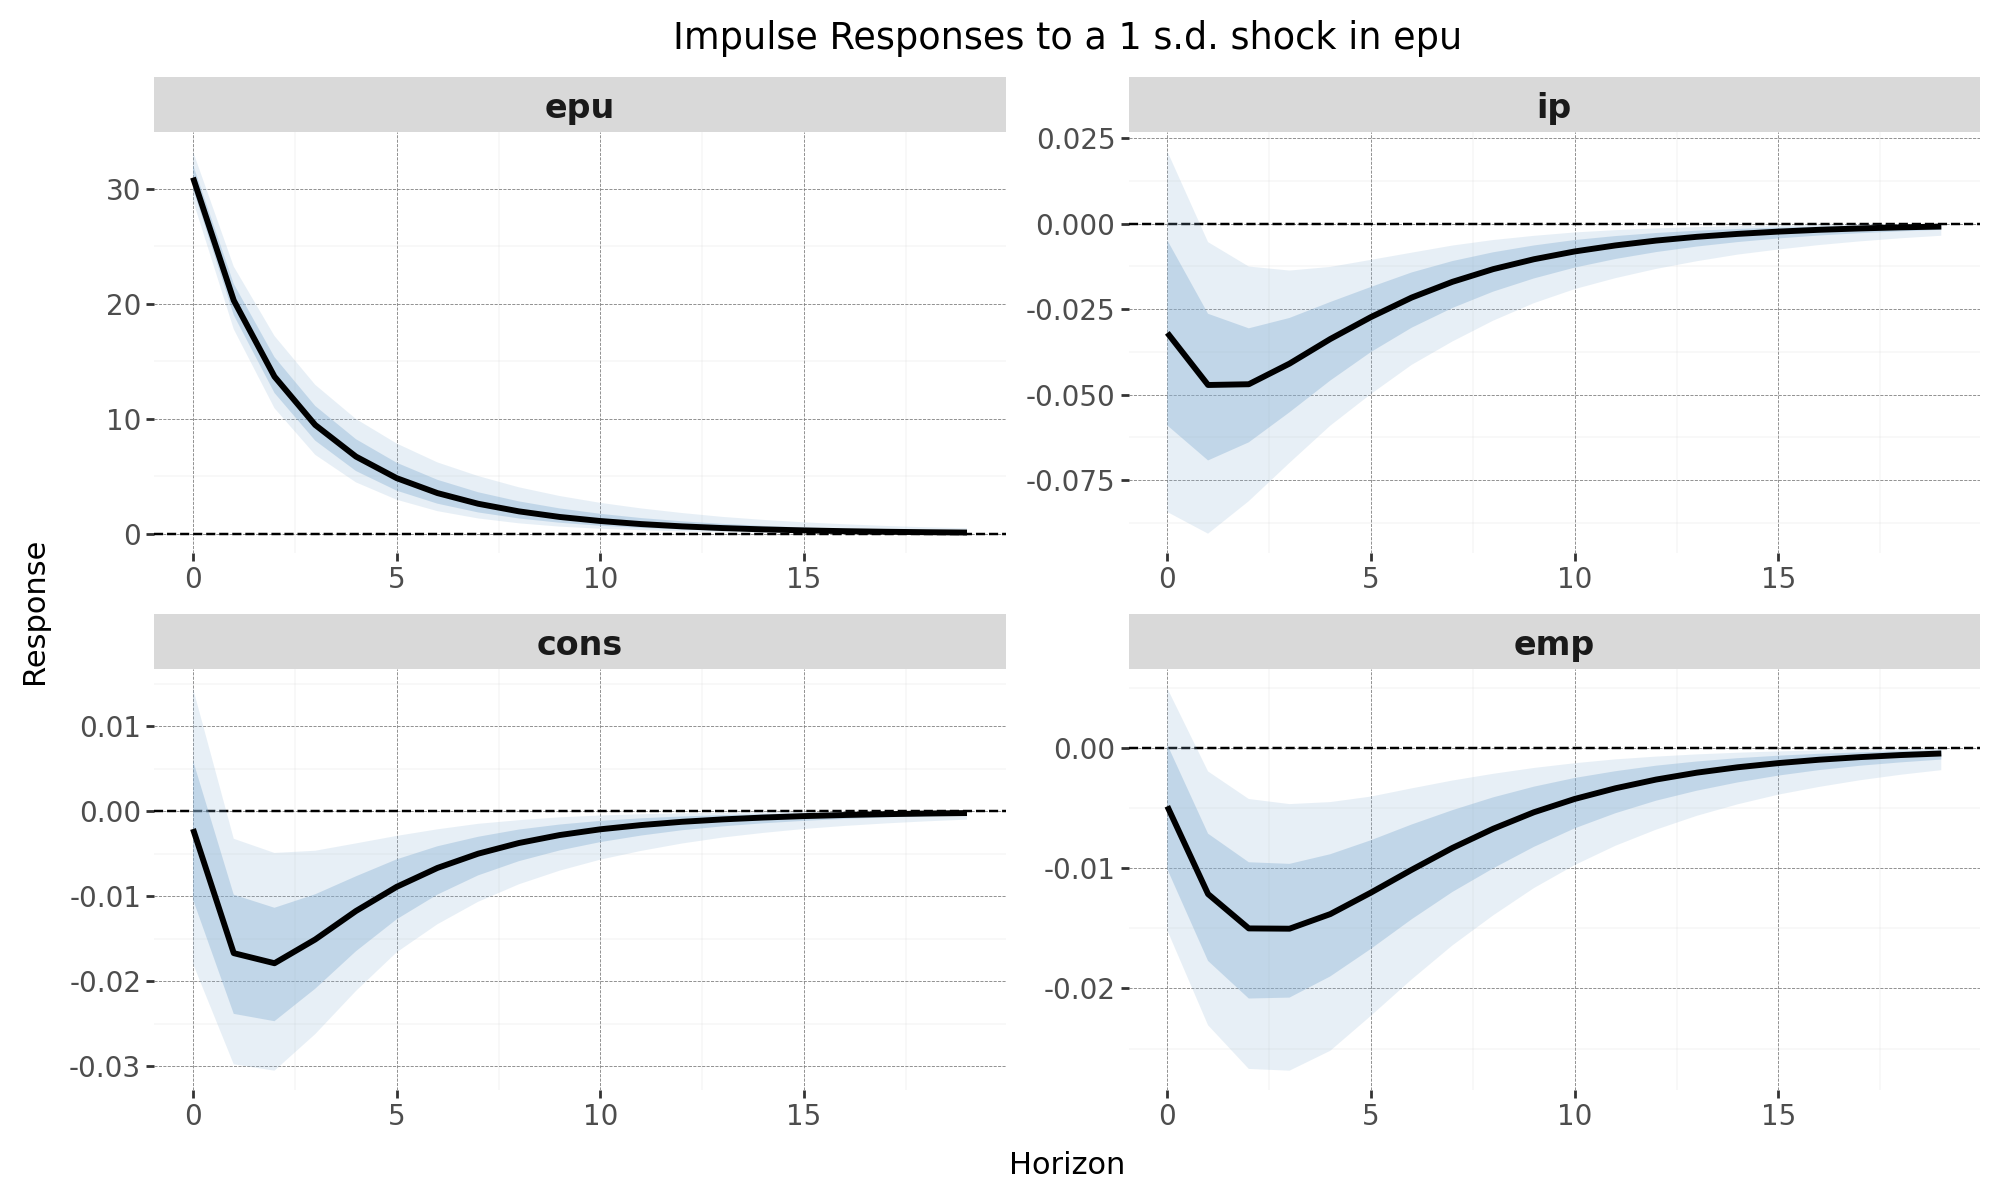

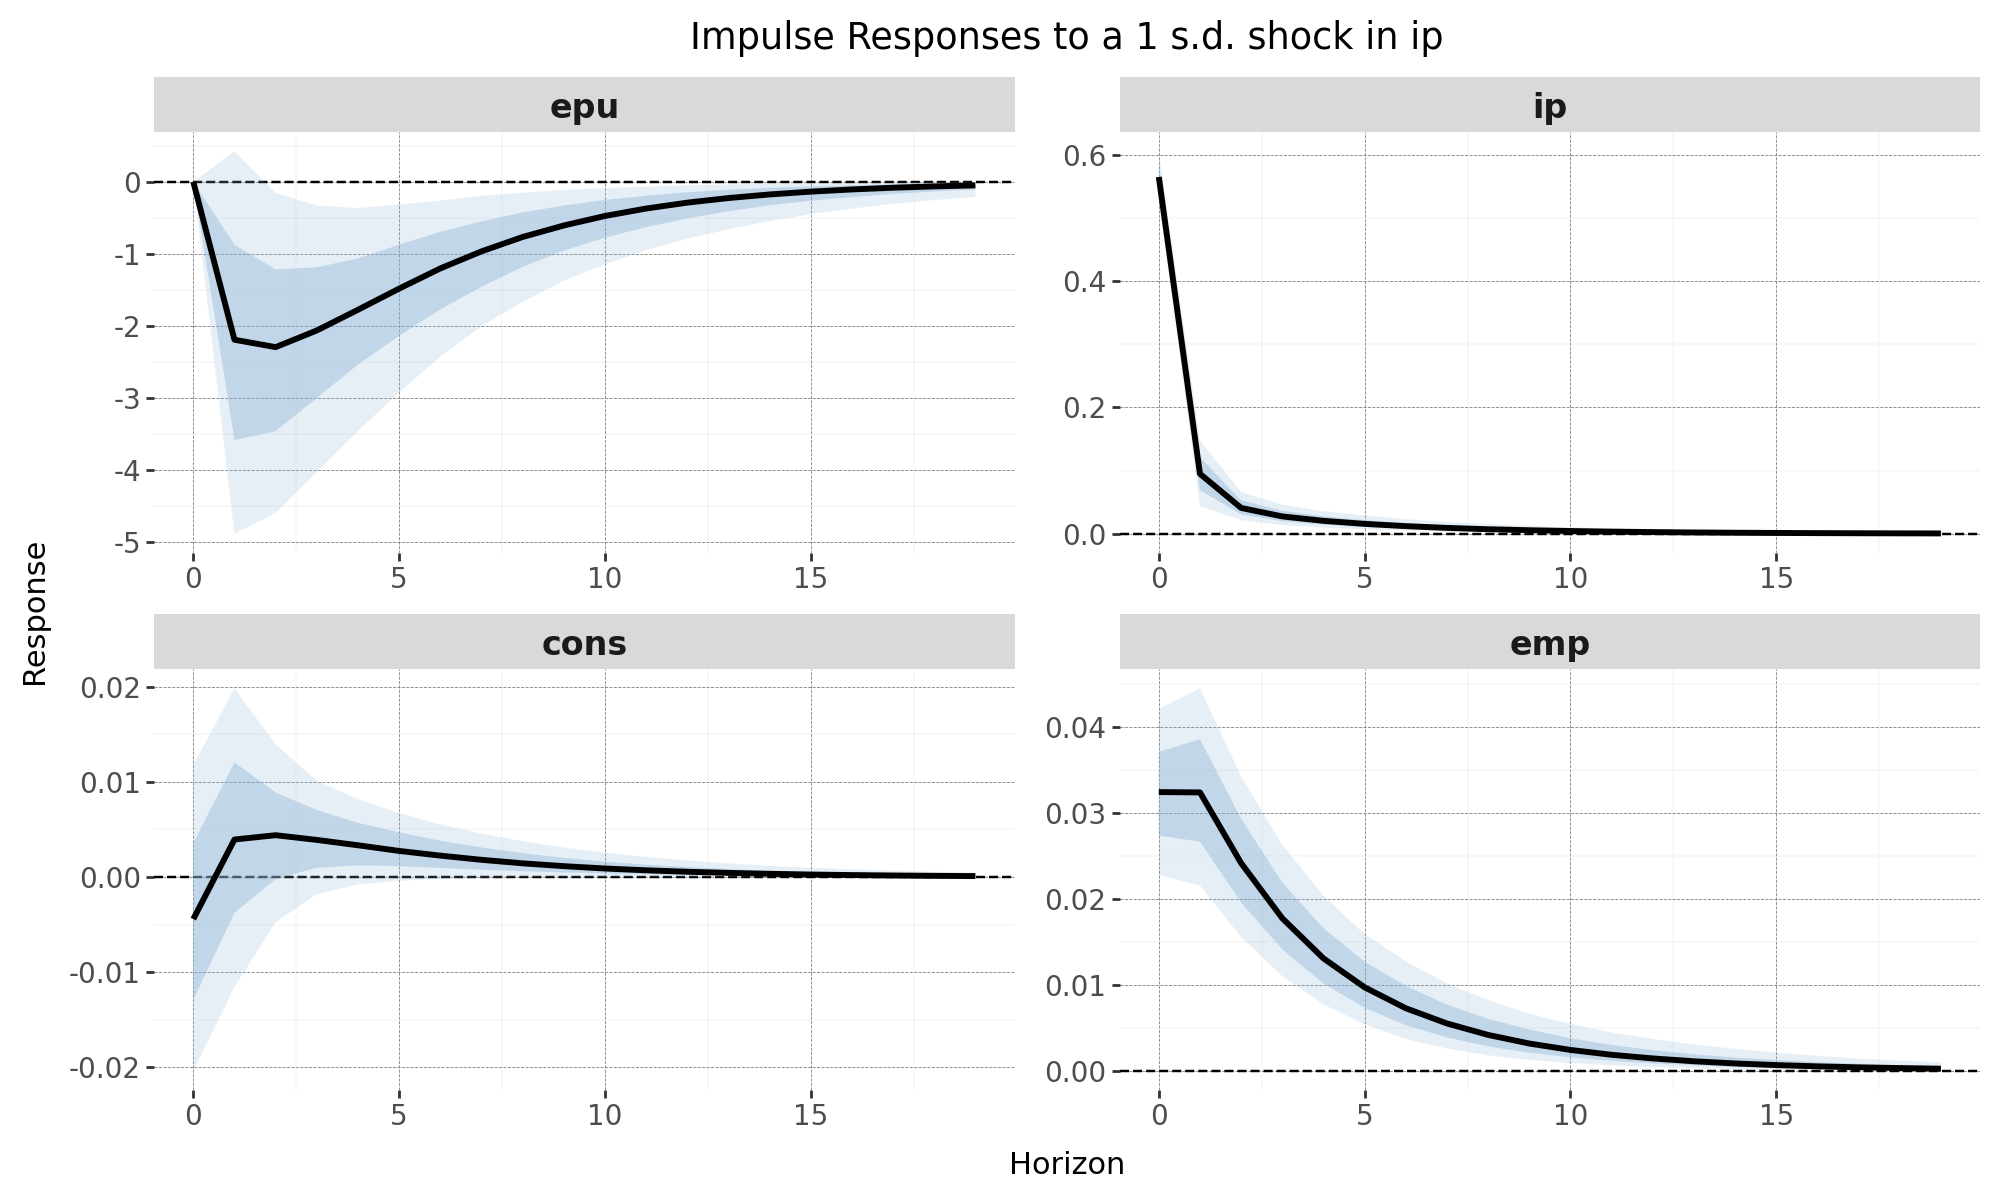

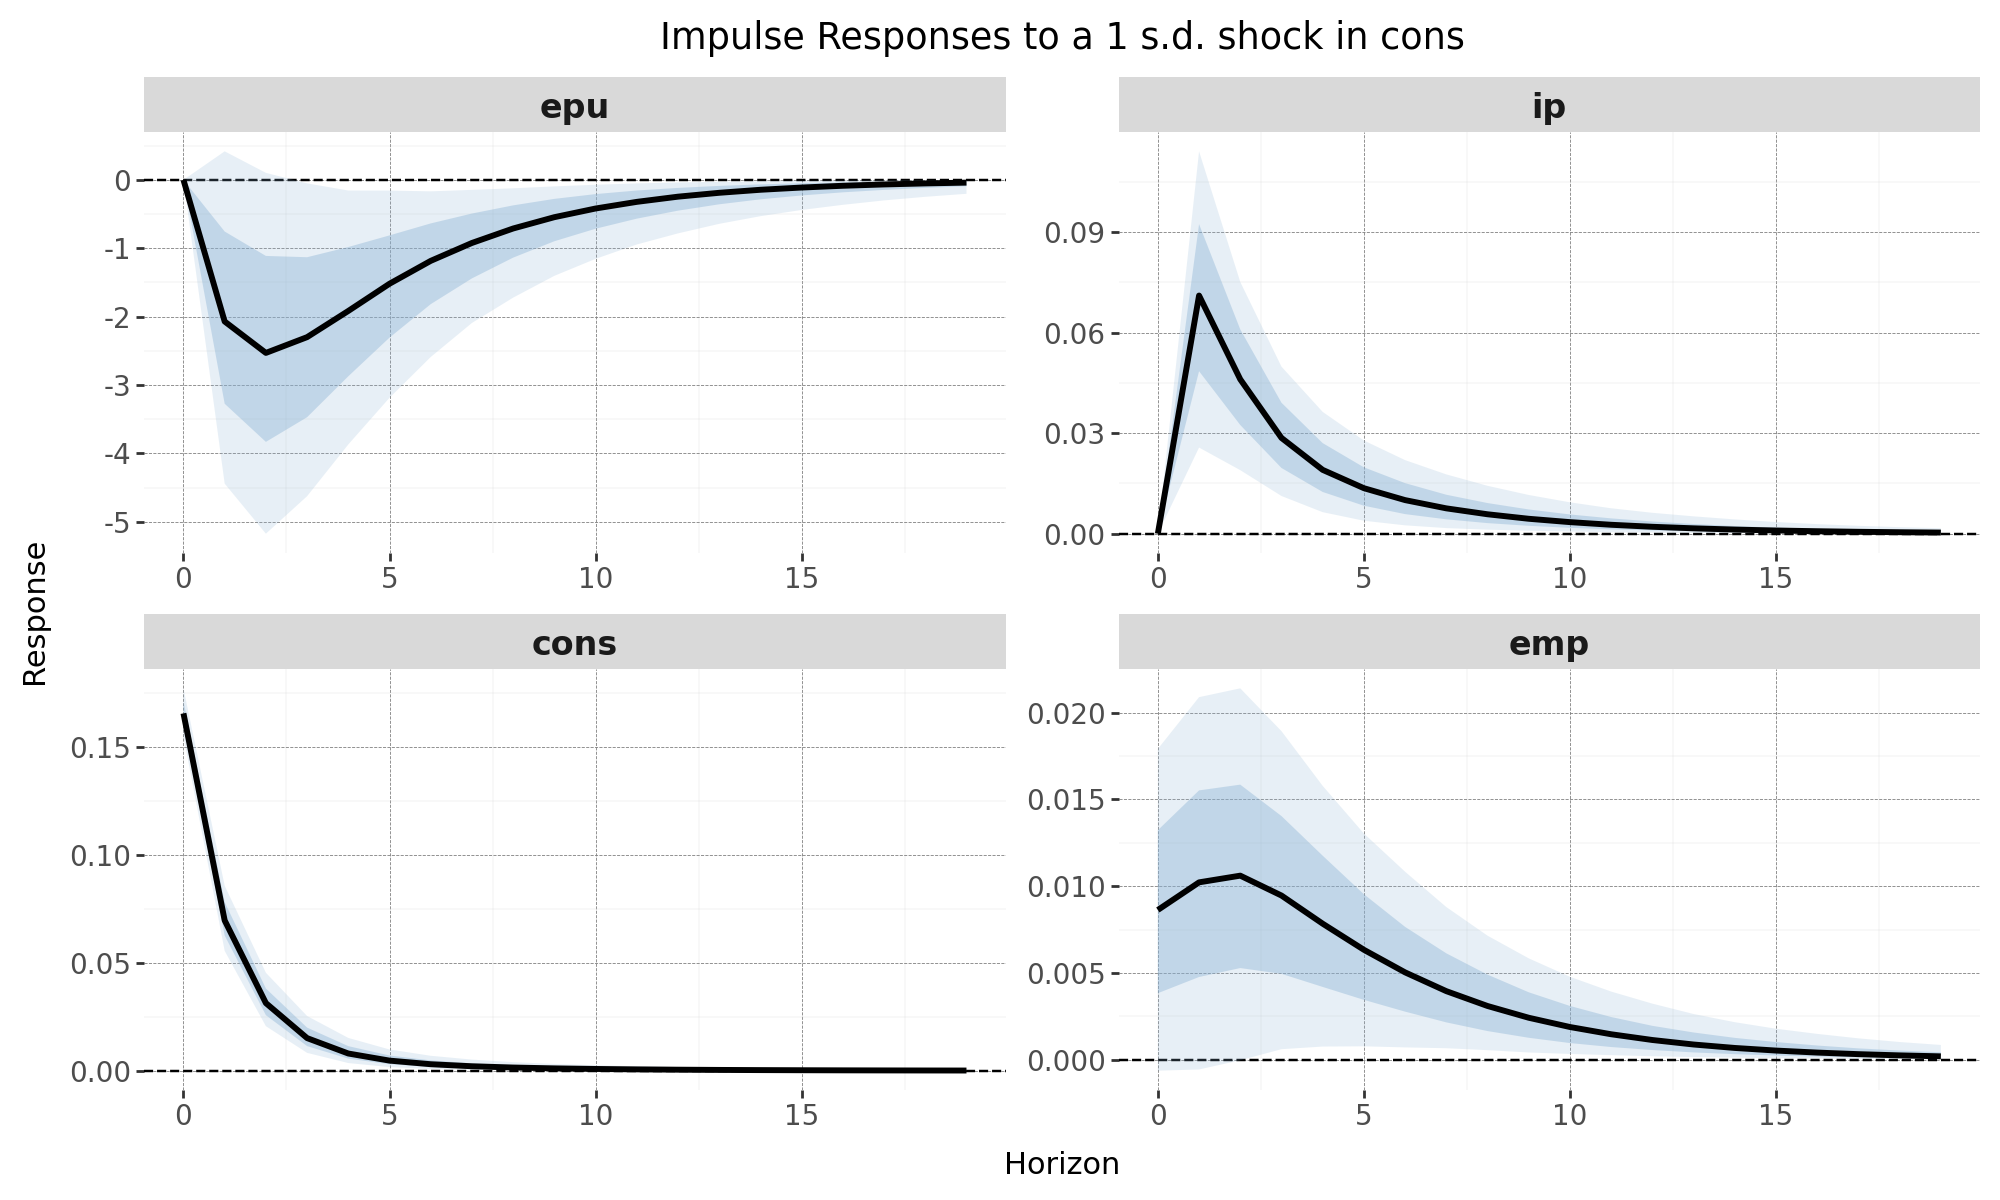

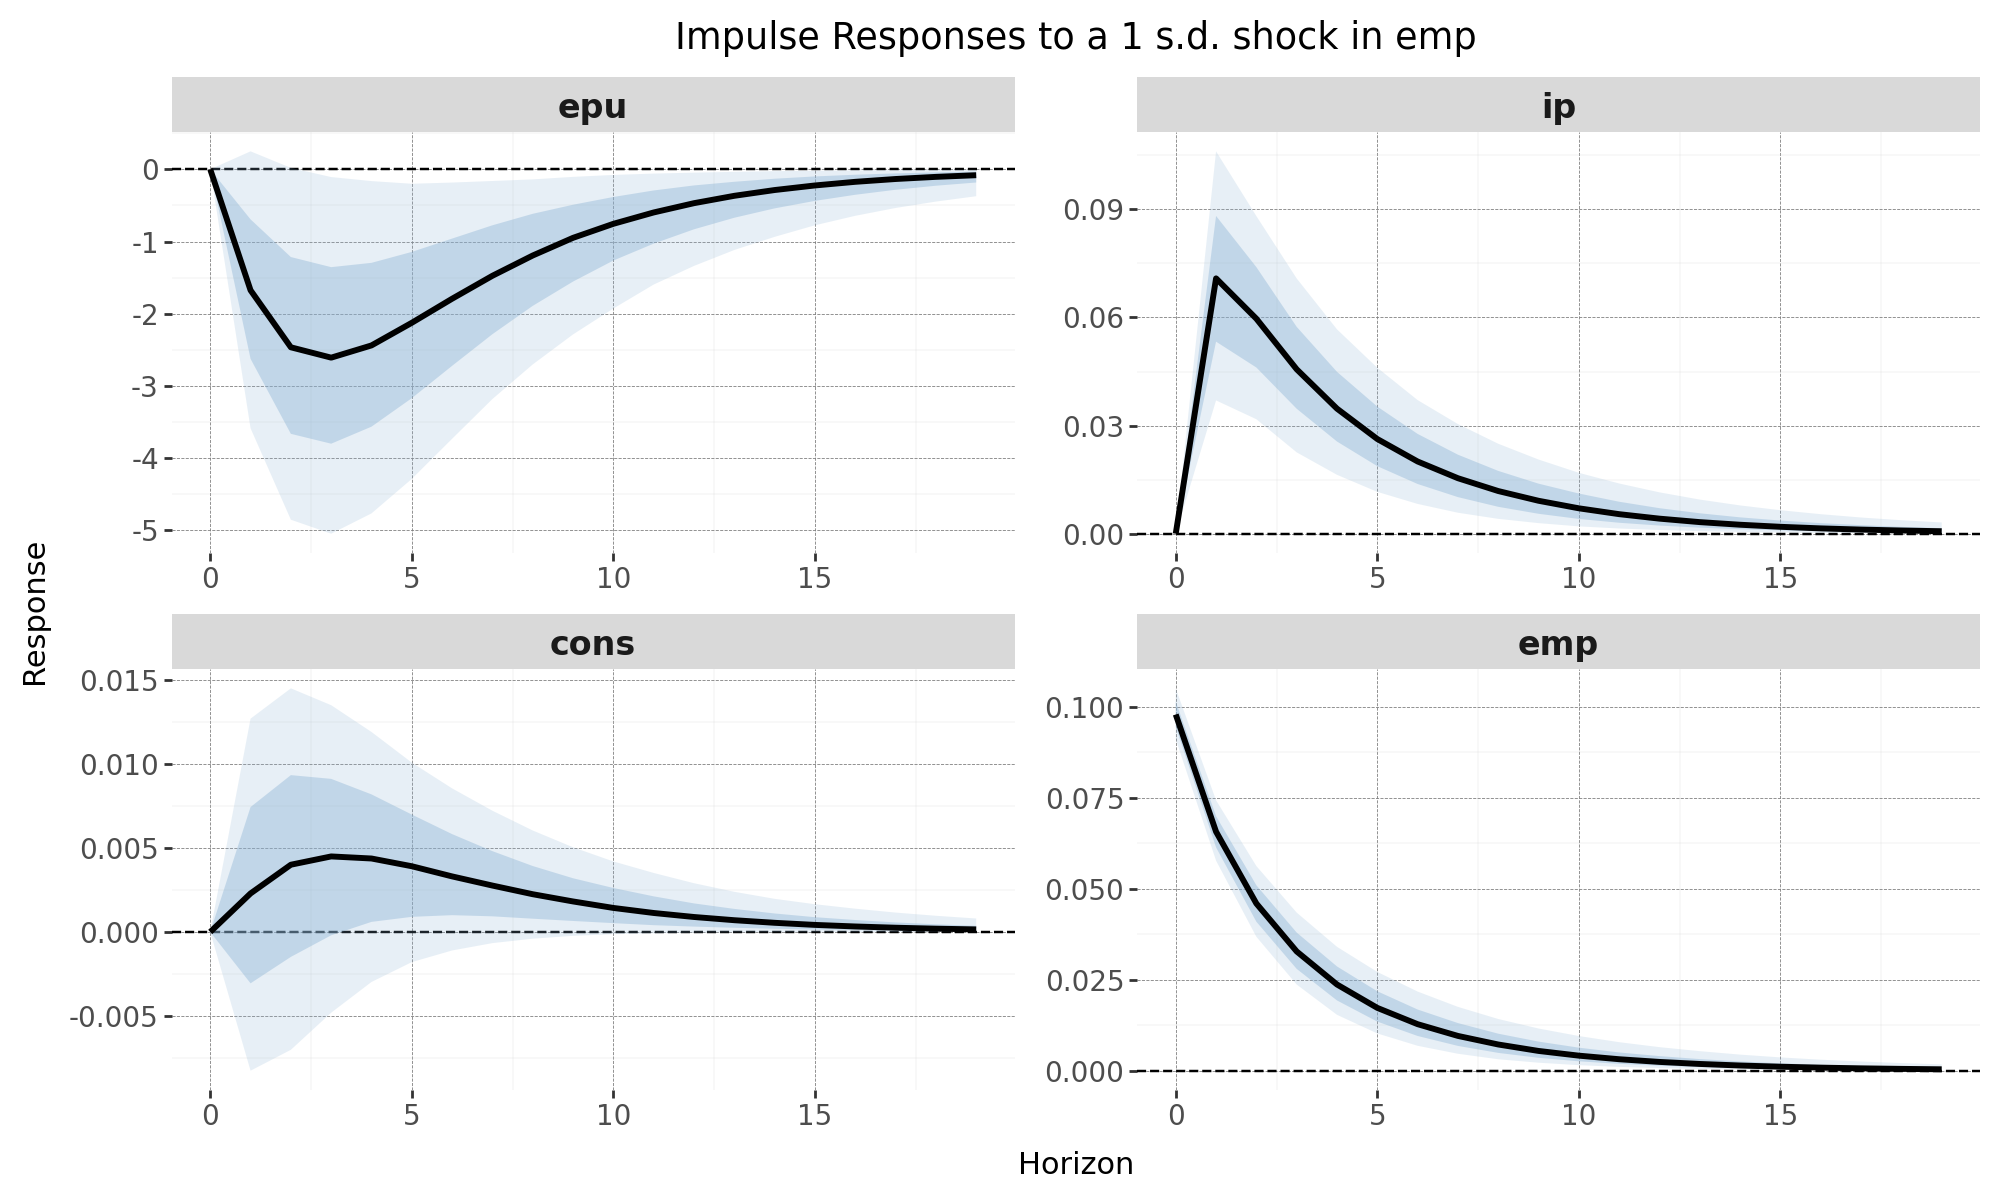

In [51]:
irfs = bvar.compute_irfs(plot_irfs=True, cred_interval=[0.68, 0.95])

The 1 s.d. EPU shock:

+ Is transient. EPU returns to baseline within a year and a half.
+ Reduces industrial production growth significantly (≈-0.05%) in the short run. This suggests firms cut back on production when uncertainty rises, likely due to delayed investment or planning.
+ Modestly reduces consumption growth (~ -0.02%). Consumers may reduce spending in response to uncertainty, possibly due to precautionary behavior or labor market concerns.
+ Employment growth declines. Firms may slow hiring or reduce hours due to uncertainty.